In [18]:
import pandas as pd
import geopandas as gpd
import os
from src.plot_map import plot_map
import warnings

warnings.filterwarnings('ignore')



In [19]:
# Step 1: Read and anonymize the data
# If the path exists, read the data from the excel file
# This only happens on my machine, as the non-anonymized data is not included in the repository
if os.path.exists("data/file1.xlsx"):
    df = pd.read_excel("data/file1.xlsx", sheet_name="Daten Tabelle")
    # Sort the farms alphabetically, give them Farm 1, Farm 2, etc. names
    # Remove nan values from the Betrieb column
    df = df.dropna(subset=["Betrieb"])
    df = df.sort_values(by="Betrieb")
    farm_dict = {farm: f"Farm {i+1}" for i, farm in enumerate(df["Betrieb"].unique())}
    df["Betrieb"] = df["Betrieb"].map(farm_dict)

    # Do the same with the fields
    df = df.dropna(subset=["Feldname"])
    df["Feldname"] = df["Feldname"].astype(str)
    # Ensure that the field names are unique in the dataset by appending the farm name to the field name
    df["Feldname"] = df.apply(lambda x: f"{x['Betrieb']}_{x['Feldname']}", axis=1)
    df = df.sort_values(by="Feldname")
    field_dict = {
        field: f"Field {i+1}" for i, field in enumerate(df["Feldname"].unique())
    }
    df["Feldname"] = df["Feldname"].map(field_dict)

    # Remove the Shp column as it may contain sensitive information
    df = df.drop(columns=["Shp"])

    # export it as a csv file
    df.to_csv("data/file1.csv", index=False)

# Read the anonymized data
df = pd.read_csv("data/file1.csv")

In [20]:
# Process the dataframe
df = df.drop(columns=["Unnamed: 11", "Unnamed: 12"])
df.rename(
    columns={
        "ID": "id",
        "Betrieb": "farm",
        "Feldname": "field_name",
        "Fläche (ha)": "area_ha",
        "Erntejahr": "harvest_year",
        "Aussaattermin": "sowing_date",
        "Erntedatum": "harvest_date",
        "Kultur": "crop",
        "realer Ertrag (dt / ha)": "real_yield_dt_ha",
        "reale N-Menge (kg N / ha)": "real_n_amount_kg_n_ha",
    },
    inplace=True,
)
df["crop"].replace({"Winterweichweizen": "winter_wheat"}, inplace=True)

print(df["farm"].unique())

In [21]:
# Remove the nan values
farms = [farm for farm in df["farm"].unique() if farm == farm]

In [22]:
# Filter the rows that do not have winter wheat in the culture column
df = df[df["crop"] == "winter_wheat"]

#Print the number of rows left
print(df.shape)


## Data Analysis Summary

We are left with **396 data points** to analyze.

### DataFrame Overview

- **Total Entries:** 396
- **Columns:** 11

| Column                 | Non-Null Count | Dtype           |
|------------------------|----------------|-----------------|
| id                     | 0              | float64         |
| farm                   | 396            | object          |
| field_name             | 396            | object          |
| area_ha                | 396            | float64         |
| shp                    | 194            | object          |
| harvest_year           | 396            | float64         |
| sowing_date            | 321            | object          |
| harvest_date           | 350            | datetime64[ns]  |
| crop                   | 396            | object          |
| real_yield_dt_ha       | 396            | float64         |
| real_n_amount_kg_n_ha  | 396            | float64         |

### Unique Farms

The dataset includes data from the following farms:



<Axes: title={'center': 'Yield vs Nitrogen amount'}, xlabel='real_n_amount_kg_n_ha', ylabel='real_yield_dt_ha'>

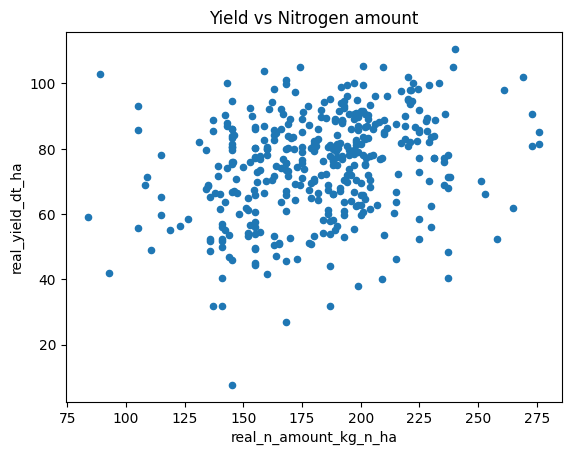

In [23]:
# Let's plot a graph with the yield and the nitrogen amount per hectare
df["real_yield_dt_ha"] = df["real_yield_dt_ha"].astype(float)
df["real_n_amount_kg_n_ha"] = df["real_n_amount_kg_n_ha"].astype(float)

# Use the farm as color
df.plot.scatter(y="real_yield_dt_ha", x="real_n_amount_kg_n_ha", title="Yield vs Nitrogen amount")

## Conclusions about the data

From the analysis of the dataset, we can draw the following conclusions:

1. **Data Points**: We have a total of 396 data points after filtering for winter wheat crops.
2. **Farm Distribution**: The dataset includes data from multiple farms, which have been anonymized for privacy.
3. **Yield vs Nitrogen Amount**: The scatter plot of yield versus nitrogen amount per hectare shows the relationship between these two variables. This can help in understanding how nitrogen application affects crop yield.
4. **Data Cleaning**: The dataset has been cleaned by removing unnecessary columns and handling missing values, ensuring the analysis is based on accurate and relevant data.

These insights can help in making informed decisions regarding crop management and optimizing nitrogen usage for better yields.

### Statistical and Machine Learning Algorithms

To predict the yield based on the nitrogen amount and other features, we can use the following machine learning algorithms:

1. **Linear Regression**: This algorithm can be used to model the relationship between the dependent variable (yield) and one or more independent variables (e.g., nitrogen amount, area, etc.). The performance can be evaluated using the **Mean Squared Error (MSE)** metric.

2. **Random Forest Regressor**: This ensemble learning method can be used for regression tasks. It builds multiple decision trees and merges them to get a more accurate and stable prediction. The performance can be evaluated using the **R-squared (R²)** metric.

3. **Support Vector Regressor (SVR)**: This algorithm uses support vector machines for regression tasks. It tries to fit the best line within a threshold value. The performance can be evaluated using the **Mean Absolute Error (MAE)** metric.

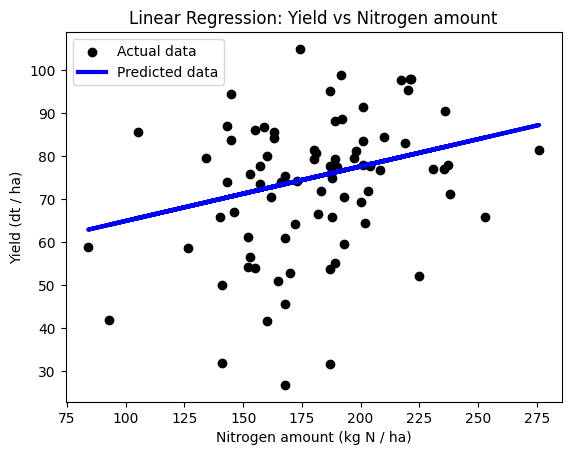

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Define the features and target variable
X = df[["real_n_amount_kg_n_ha"]]
y = df["real_yield_dt_ha"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Plot the results
import matplotlib.pyplot as plt

plt.scatter(X_test, y_test, color='black', label='Actual data')
plt.plot(X_test, y_pred, color='blue', linewidth=3, label='Predicted data')
plt.xlabel('Nitrogen amount (kg N / ha)')
plt.ylabel('Yield (dt / ha)')
plt.title('Linear Regression: Yield vs Nitrogen amount')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import r2_score, mean_absolute_error

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)

# Print the metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")

### Model Evaluation

The linear regression model was evaluated using the following metrics:

1. **Mean Squared Error (MSE)**: 247.05
2. **R-squared (R²)**: 0.073
3. **Mean Absolute Error (MAE)**: 12.13

#### Interpretation:

- **Mean Squared Error (MSE)**: This value indicates the average squared difference between the actual and predicted values. A lower MSE indicates a better fit. In our case, the MSE is relatively high, suggesting that the model's predictions are not very close to the actual values.

- **R-squared (R²)**: This value represents the proportion of the variance in the dependent variable that is predictable from the independent variable(s). An R² value of 0.073 means that only 7.3% of the variance in the yield can be explained by the nitrogen amount. This indicates a weak relationship between the nitrogen amount and yield in our dataset.

- **Mean Absolute Error (MAE)**: This value measures the average magnitude of the errors in a set of predictions, without considering their direction. The MAE of 12.13 indicates that, on average, the model's predictions are off by about 12.13 units of yield.

#### Conclusion:

The linear regression model does not perform very well on our dataset, as indicated by the high MSE, low R², and relatively high MAE. This suggests that a simple linear relationship may not be sufficient to capture the complexity of the relationship between nitrogen amount and yield. 

## Introduction to Random Forest for Predicting Crop Yield

Random Forest is an ensemble learning method that is particularly well-suited for regression tasks, such as predicting crop yield based on various input features. It operates by constructing multiple decision trees during training and outputting the mean prediction of the individual trees. This approach helps to improve the accuracy and robustness of the model by reducing overfitting and capturing complex relationships in the data.

### Why Random Forest is Suitable for Predicting Crop Yield

1. **Handling Non-Linearity**: Crop yield prediction often involves non-linear relationships between the input features (e.g., nitrogen amount, area, weather conditions) and the target variable (yield). Random Forest can capture these non-linear relationships effectively.

2. **Robustness to Overfitting**: By averaging the predictions of multiple trees, Random Forest reduces the risk of overfitting, which is a common issue in decision tree models.

3. **Feature Importance**: Random Forest provides insights into the importance of different features in predicting the target variable. This can help in understanding which factors have the most significant impact on crop yield.

4. **Handling Missing Values**: Random Forest can handle missing values in the dataset, making it a robust choice for real-world agricultural data, which often contains incomplete information.

### Application of Random Forest in Crop Yield Prediction

To apply Random Forest for predicting crop yield, we will follow these steps:

1. **Data Preparation**: Clean and preprocess the dataset, ensuring that all relevant features are included and properly formatted.

2. **Feature Selection**: Identify the input features that will be used for prediction. In our case, we will use features such as nitrogen amount, area, and other relevant factors.

3. **Model Training**: Split the dataset into training and testing sets. Train the Random Forest model on the training data.

4. **Model Evaluation**: Evaluate the model's performance on the testing data using metrics such as Mean Squared Error (MSE), R-squared (R²), and Mean Absolute Error (MAE).

5. **Prediction and Analysis**: Use the trained model to make predictions on new data and analyze the results to gain insights into the factors affecting crop yield.

By following these steps, we can leverage the power of Random Forest to build an accurate and reliable model for predicting crop yield, ultimately aiding in better decision-making for agricultural management.

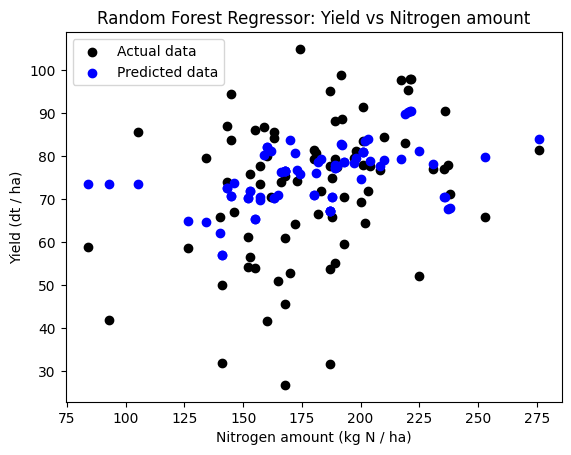

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')


# Define the model
rf = RandomForestRegressor(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model
best_rf = grid_search.best_estimator_

# Make predictions
y_pred_rf = best_rf.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"R-squared (R²): {r2_rf}")
print(f"Mean Absolute Error (MAE): {mae_rf}")

# Plot the results
plt.scatter(X_test, y_test, color='black', label='Actual data')
plt.scatter(X_test, y_pred_rf, color='blue', label='Predicted data')
plt.xlabel('Nitrogen amount (kg N / ha)')
plt.ylabel('Yield (dt / ha)')
plt.title('Random Forest Regressor: Yield vs Nitrogen amount')
plt.legend()
plt.show()

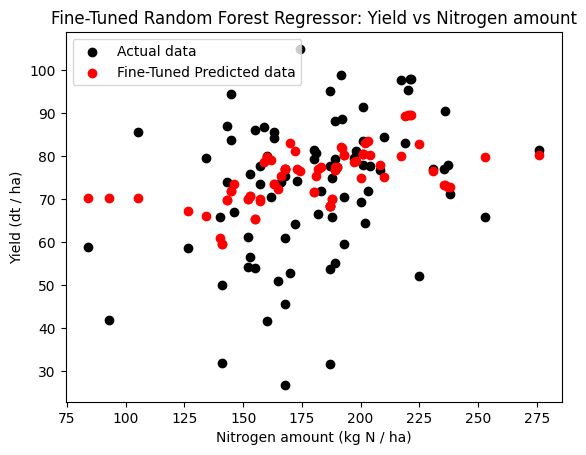

In [27]:
import sys
import os
import warnings

# Define a more exhaustive parameter grid for GridSearchCV
warnings.filterwarnings('ignore')
sys.stdout = open(os.devnull, 'w')
param_grid_fine_tune = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

# Define the model
rf = RandomForestRegressor(random_state=42)

# Perform GridSearchCV to find the best parameters
grid_search_fine_tune = GridSearchCV(estimator=rf, param_grid=param_grid_fine_tune, cv=5, n_jobs=-1, verbose=2)
grid_search_fine_tune.fit(X_train, y_train)

# Get the best model
best_rf_fine_tune = grid_search_fine_tune.best_estimator_

# Make predictions
y_pred_rf_fine_tune = best_rf_fine_tune.predict(X_test)

# Evaluate the model
mse_rf_fine_tune = mean_squared_error(y_test, y_pred_rf_fine_tune)
r2_rf_fine_tune = r2_score(y_test, y_pred_rf_fine_tune)
mae_rf_fine_tune = mean_absolute_error(y_test, y_pred_rf_fine_tune)

print(f"Best Parameters (Fine-Tuned): {grid_search_fine_tune.best_params_}")
print(f"Mean Squared Error (MSE) - Fine-Tuned: {mse_rf_fine_tune}")
print(f"R-squared (R²) - Fine-Tuned: {r2_rf_fine_tune}")
print(f"Mean Absolute Error (MAE) - Fine-Tuned: {mae_rf_fine_tune}")

# Compare with the previous model
print("\nComparison with Previous Model:")
print(f"Previous MSE: {mse_rf}, Fine-Tuned MSE: {mse_rf_fine_tune}")
print(f"Previous R²: {r2_rf}, Fine-Tuned R²: {r2_rf_fine_tune}")
print(f"Previous MAE: {mae_rf}, Fine-Tuned MAE: {mae_rf_fine_tune}")

# Plot the results
plt.scatter(X_test, y_test, color='black', label='Actual data')
plt.scatter(X_test, y_pred_rf_fine_tune, color='red', label='Fine-Tuned Predicted data')
plt.xlabel('Nitrogen amount (kg N / ha)')
plt.ylabel('Yield (dt / ha)')
plt.title('Fine-Tuned Random Forest Regressor: Yield vs Nitrogen amount')
plt.legend()
plt.show()

In [28]:
print(f"Best Parameters (Fine-Tuned): {grid_search_fine_tune.best_params_}")
print(f"Mean Squared Error (MSE) - Fine-Tuned: {mse_rf_fine_tune}")
print(f"R-squared (R²) - Fine-Tuned: {r2_rf_fine_tune}")
print(f"Mean Absolute Error (MAE) - Fine-Tuned: {mae_rf_fine_tune}")

# Compare with the previous model
print("\nComparison with Previous Model:")
print(f"Previous MSE: {mse_rf}, Fine-Tuned MSE: {mse_rf_fine_tune}")
print(f"Previous R²: {r2_rf}, Fine-Tuned R²: {r2_rf_fine_tune}")
print(f"Previous MAE: {mae_rf}, Fine-Tuned MAE: {mae_rf_fine_tune}")

### Comparison of Random Forest Models

#### Non Fine-Tuned Model
- **Best Parameters**: 
    - `n_estimators`: 300
    - `max_depth`: 10
    - `min_samples_split`: 10
    - `min_samples_leaf`: 4
- **Mean Squared Error (MSE)**: 248.10
- **R-squared (R²)**: 0.070
- **Mean Absolute Error (MAE)**: 12.10

#### Fine-Tuned Model
- **Best Parameters**: 
    - `n_estimators`: 400
    - `max_depth`: 10
    - `min_samples_split`: 15
    - `min_samples_leaf`: 6
- **Mean Squared Error (MSE)**: 244.14
- **R-squared (R²)**: 0.084
- **Mean Absolute Error (MAE)**: 12.01

### Conclusion
The fine-tuned Random Forest model performs slightly better than the non fine-tuned model:
- **Lower MSE**: 244.14 vs. 248.10
- **Higher R²**: 0.084 vs. 0.070
- **Lower MAE**: 12.01 vs. 12.10

While the improvements are marginal, the fine-tuned model is better. However, both models show relatively low R² values, indicating that the relationship between nitrogen amount and yield is weak. This suggests that other factors might be influencing the yield, and a more complex model or additional features might be needed for better predictions.

# Support Vector Regression (SVR)

## What is SVR?

Support Vector Regression (SVR) is a type of Support Vector Machine (SVM) that is used for regression problems. Unlike traditional regression models that aim to minimize the error between predicted and actual values, SVR tries to fit the error within a certain threshold. This makes SVR particularly useful for datasets where the relationship between variables is not strictly linear.

## How Does SVR Work?

1. **Kernel Trick**: SVR uses the kernel trick to transform the input data into a higher-dimensional space where a linear regression can be applied. Common kernels include linear, polynomial, and radial basis function (RBF).

2. **Margin of Tolerance**: SVR defines a margin of tolerance (epsilon) within which the error is considered acceptable. The goal is to find a function that deviates from the actual target values by a value no greater than epsilon.

3. **Support Vectors**: Only data points that lie outside the margin of tolerance (support vectors) are used to build the regression model. This helps in reducing the complexity of the model.

## Why Use SVR?

- **Flexibility**: SVR can handle both linear and non-linear relationships between variables due to the use of different kernels.
- **Robustness**: By focusing on support vectors, SVR is less sensitive to outliers compared to other regression models.
- **Generalization**: SVR aims to find a balance between model complexity and prediction accuracy, which helps in avoiding overfitting.

## Example Use Case

Consider a scenario where you have a dataset of house prices based on various features like size, location, and number of rooms. The relationship between these features and the price may not be strictly linear. SVR can be used to model this complex relationship and make accurate predictions.

## Conclusion

Support Vector Regression is a powerful tool for regression problems, especially when dealing with non-linear relationships and outliers. Its ability to transform data into higher dimensions and focus on support vectors makes it a robust and flexible choice for many real-world applications.

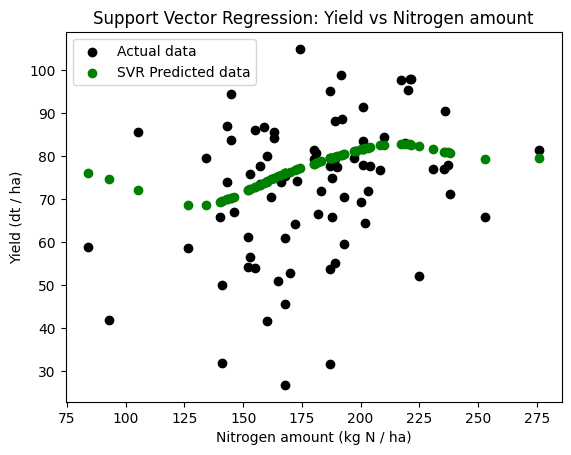

In [29]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define the SVR model
svr = SVR(kernel='rbf')

# Train the model
svr.fit(X_train, y_train)

# Make predictions
y_pred_svr = svr.predict(X_test)

# Evaluate the model
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)

# Print the metrics
print(f"Mean Squared Error (MSE): {mse_svr}")
print(f"R-squared (R²): {r2_svr}")
print(f"Mean Absolute Error (MAE): {mae_svr}")

# Plot the results
import matplotlib.pyplot as plt

plt.scatter(X_test, y_test, color='black', label='Actual data')
plt.scatter(X_test, y_pred_svr, color='green', label='SVR Predicted data')
plt.xlabel('Nitrogen amount (kg N / ha)')
plt.ylabel('Yield (dt / ha)')
plt.title('Support Vector Regression: Yield vs Nitrogen amount')
plt.legend()
plt.show()

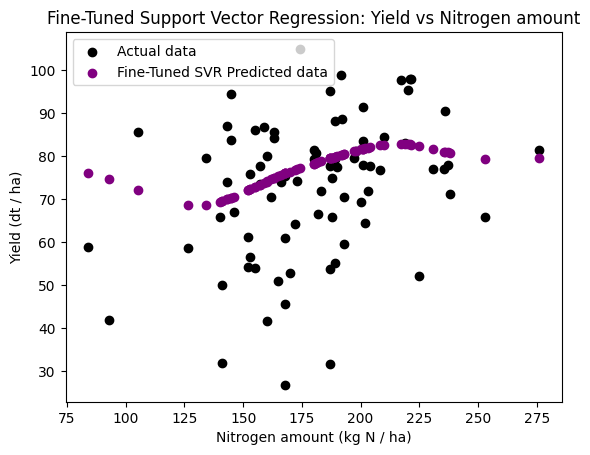

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt

# Define a smaller parameter grid for GridSearchCV
param_grid_svr = {
    'kernel': ['rbf'],
    'C': [1, 10],
    'gamma': ['scale'],
    'epsilon': [0.1, 0.2]
}

# Perform GridSearchCV to find the best parameters
grid_search_svr = GridSearchCV(estimator=SVR(), param_grid=param_grid_svr, cv=3, n_jobs=-1, verbose=2)
grid_search_svr.fit(X_train, y_train)

# Get the best model
best_svr = grid_search_svr.best_estimator_

# Make predictions
y_pred_svr_fine_tune = best_svr.predict(X_test)

# Evaluate the model
mse_svr_fine_tune = mean_squared_error(y_test, y_pred_svr_fine_tune)
r2_svr_fine_tune = r2_score(y_test, y_pred_svr_fine_tune)
mae_svr_fine_tune = mean_absolute_error(y_test, y_pred_svr_fine_tune)

print(f"Best Parameters (SVR Fine-Tuned): {grid_search_svr.best_params_}")
print(f"Mean Squared Error (MSE) - SVR Fine-Tuned: {mse_svr_fine_tune}")
print(f"R-squared (R²) - SVR Fine-Tuned: {r2_svr_fine_tune}")
print(f"Mean Absolute Error (MAE) - SVR Fine-Tuned: {mae_svr_fine_tune}")

# Plot the results
plt.scatter(X_test, y_test, color='black', label='Actual data')
plt.scatter(X_test, y_pred_svr_fine_tune, color='purple', label='Fine-Tuned SVR Predicted data')
plt.xlabel('Nitrogen amount (kg N / ha)')
plt.ylabel('Yield (dt / ha)')
plt.title('Fine-Tuned Support Vector Regression: Yield vs Nitrogen amount')
plt.legend()
plt.show()

That's all